In [1]:
import numpy as np

from scipy import integrate

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
import emcee
import corner

(0.30053995921242305, 0.699460040787577, 0.9999999999996116)

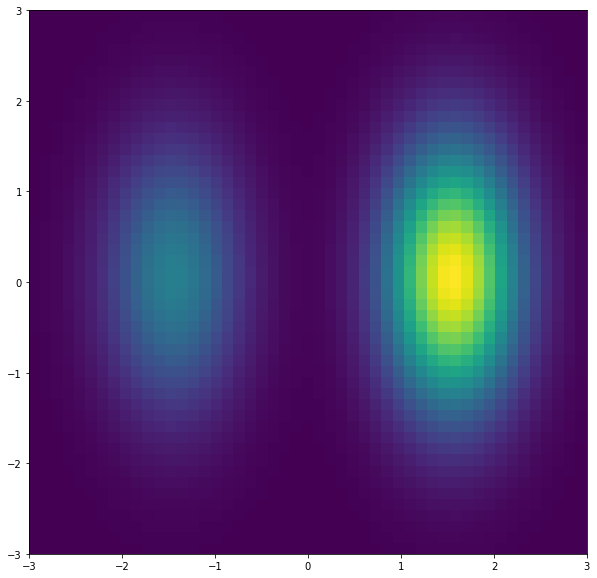

In [4]:
def lnp(theta, fracA):
    x, y = theta
    A = 2*fracA
    B = 2*(1-fracA)
    return np.logaddexp(-0.5*((x-1.5)/0.5)**2 + np.log(B), -0.5*((x+1.5)/0.5)**2 + np.log(A)) - 0.5*(y)**2 - np.log(2*np.pi)

dimlabels = ['x', 'y']

fiducial_frac = 0.3


xg, yg = np.mgrid[-3:3:50j, -3:3:50j]

plt.figure(figsize=(10, 10))
plt.pcolor(xg, yg, np.exp(lnp((xg, yg), fiducial_frac)))

iextent = 50
tot = integrate.dblquad(lambda y,x:np.exp(lnp((x, y), fiducial_frac)), -iextent, iextent, lambda x:-iextent, lambda x:iextent)[0]
left = integrate.dblquad(lambda y,x:np.exp(lnp((x, y), fiducial_frac)), -iextent, 0, lambda x:-iextent, lambda x:iextent)[0]
right = integrate.dblquad(lambda y,x:np.exp(lnp((x, y), fiducial_frac)), 0, iextent, lambda x:-iextent, lambda x:iextent)[0]
left/tot, right/tot, tot

# How does the Ensemble sampler do? 

In [5]:
def do_ensemble(nwalkers, niters, burnin=100, frac=fiducial_frac, plots=True):
    sampler = emcee.EnsembleSampler(nwalkers, 2, lnp, args=[frac])

    p0 = emcee.utils.sample_ball([0,0], [1,1], nwalkers)
    if burnin:
        p0 = sampler.run_mcmc(p0, burnin)[0]
        sampler.reset()
    res = sampler.run_mcmc(p0, niters)

    if plots:
        try:
            acor = sampler.acor
        except Exception as e:
            print('Got', e, 'while getting acor')
            acor = None #got the "too short" error, probably

        plt.figure(figsize=(12, 8))
        for i,var in enumerate(sampler.chain.T):
            plt.subplot(2, 1, i+1)
            plt.plot(var)
            plt.ylabel(dimlabels[i])
            if acor is not None:
                plt.title('acor={:.1f}'.format(acor[i]))

        corner.corner(sampler.flatchain, labels=dimlabels)

    xsamps, ysamps = sampler.flatchain.T
    return np.sum(xsamps<0)/len(xsamps), np.sum(xsamps>0)/len(xsamps)

A longg-enough chain will do it

(0.30193166666666665, 0.69806833333333329)

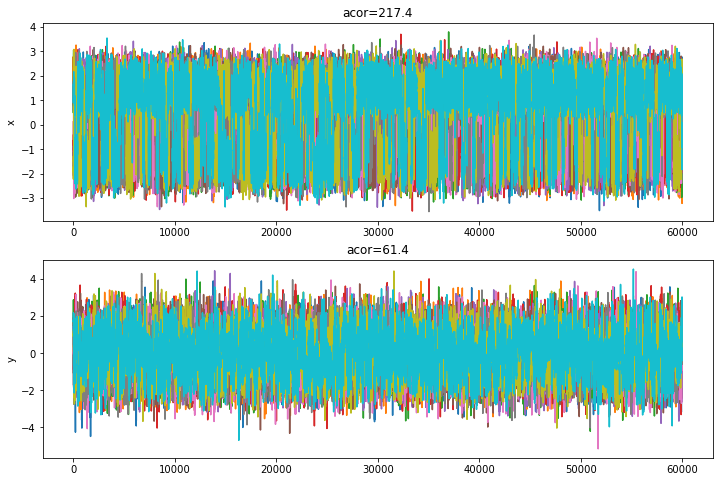

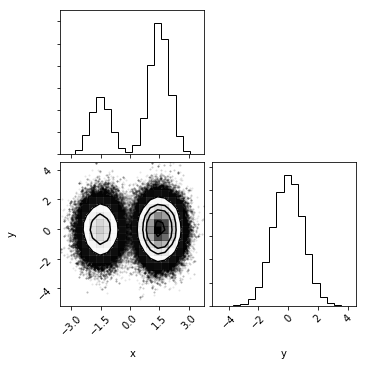

In [6]:
do_ensemble(10, 60000)

But you get a lot of answers if you don't sample enough...

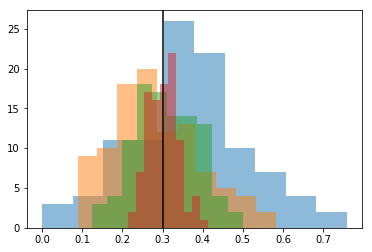

In [7]:
def ensemble_ensemble(ntries, nwalkers, niters, burnin=100):
    As = []
    Bs = []
    for i in range(ntries):
        fA, fB = do_ensemble(nwalkers, niters, burnin, plots=False)
        As.append(fA)
        Bs.append(fB)
    return np.array(As)
    
plt.hist(ensemble_ensemble(100, 6, 100), alpha=.5)
plt.hist(ensemble_ensemble(100, 6, 500), alpha=.5)
plt.hist(ensemble_ensemble(100, 6, 1500), alpha=.5)
plt.hist(ensemble_ensemble(100, 20, 1500), alpha=.5)

plt.axvline(0.3, c='k')

# What about 'ol metropolis-hastings? 

In [8]:
def do_mh(cov, niters, burnin=100, plots=True):
    mhsampler = emcee.MHSampler(cov, 2, lnp, args=[fiducial_frac])
    
    p0 = emcee.utils.sample_ball([0,0], [1,1], 1)[0]
    if burnin:
        p0 = mhsampler.run_mcmc(p0, burnin)[0]
        mhsampler.reset()
    res = mhsampler.run_mcmc(p0, niters)

    if plots:
        try:
            acor = mhsampler.acor
        except Exception as e:
            print('Got', e, 'while getting acor')
            acor = None #got the "too short" error, probably
            
        plt.figure(figsize=(12, 8))
        for i,var in enumerate(mhsampler.chain.T):
            plt.subplot(2, 1, i+1)
            plt.plot(var)
            plt.ylabel(dimlabels[i])
            if acor is not None:
                plt.title('acor={:.1f}'.format(acor[i]))

        corner.corner(mhsampler.chain, labels=dimlabels)    

    xsamps, ysamps = mhsampler.chain.T
    return np.sum(xsamps<0)/len(xsamps), np.sum(xsamps>0)/len(xsamps)

The reliability over the modes depends on the covariance matrix

(0.3135, 0.6865)

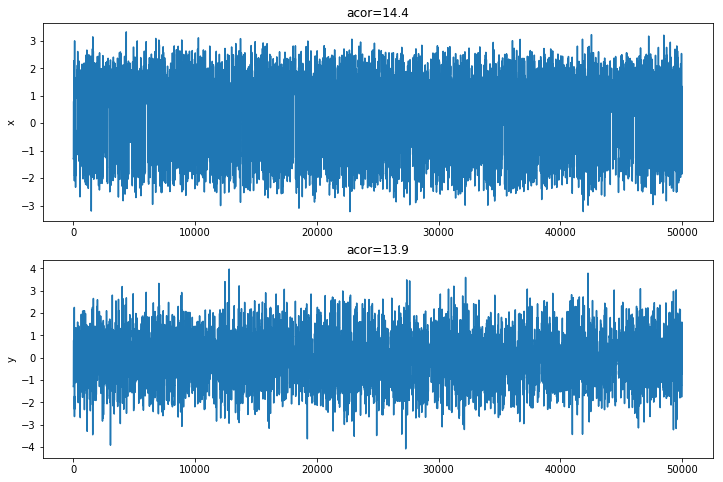

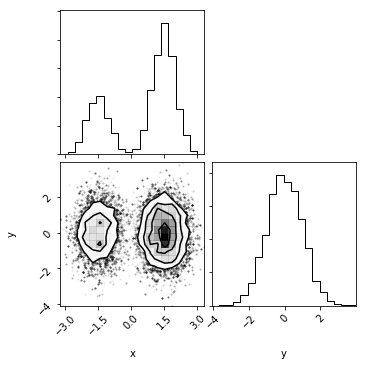

In [9]:
do_mh(np.eye(2)*10, 50000)

(0.29483999999999999, 0.70516000000000001)

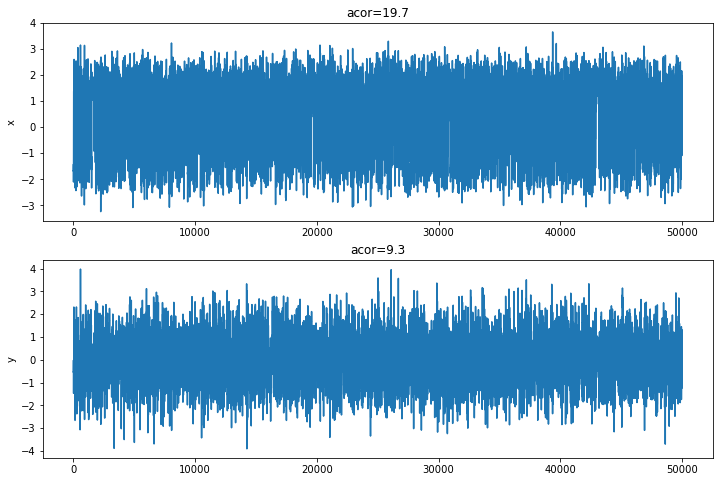

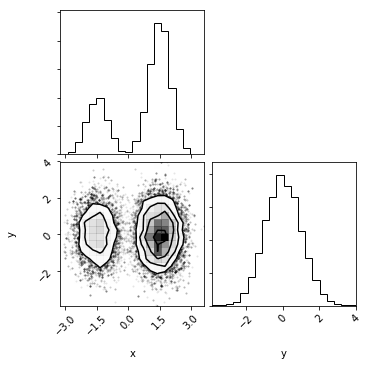

In [10]:
do_mh(np.eye(2)*5, 50000)

(0.30514000000000002, 0.69486000000000003)

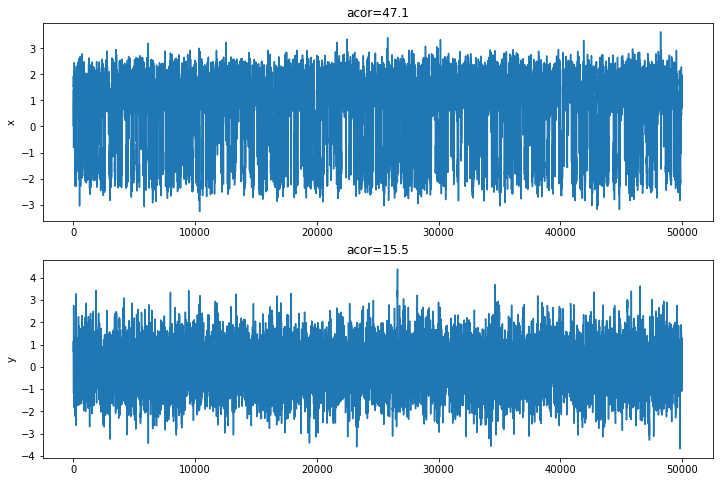

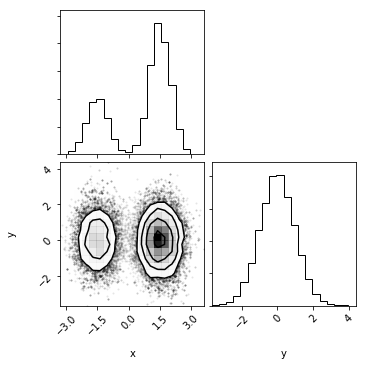

In [11]:
do_mh(np.eye(2)*1, 50000)

Got The chain is too short to reliably estimate the autocorrelation time while getting acor


(0.26844000000000001, 0.73155999999999999)

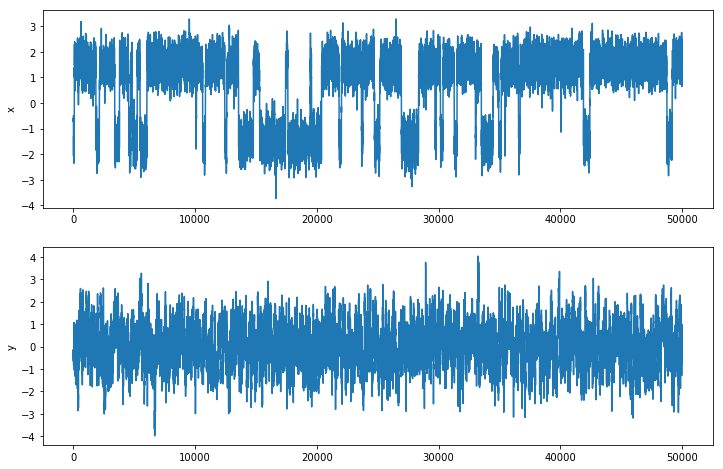

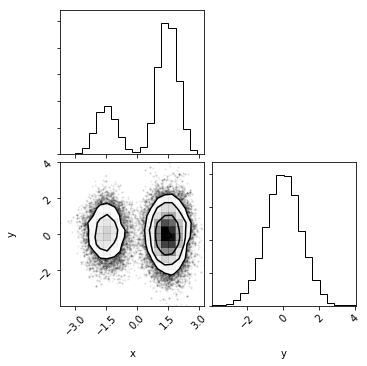

In [12]:
do_mh(np.eye(2)*.1, 50000)

# And paralell tempering? 

In [15]:
def do_pt(ntemps, nwalkers, niters, burnin=100, frac=fiducial_frac, plots=True,
          symtemps=True):
    if symtemps:
        betas = np.logspace(-1,1, ntemps)[::-1]
    else:
        betas = None
    
    ptsampler = emcee.PTSampler(ntemps, nwalkers, 2, lnp, lambda x:0., 
                                loglargs=[frac], betas=betas)
    
    print('Temps',1/ptsampler.betas)
    
    p0 =  np.random.normal(size=(ntemps, nwalkers, 2))
    if burnin:
        p0 = ptsampler.run_mcmc(p0, burnin)[0]
        ptsampler.reset()
    res = ptsampler.run_mcmc(p0, niters)

    #return ptsampler
    if plots:
        try:
            acor = ptsampler.acor
        except Exception as e:
            print('Got', e, 'while getting acor')
            acor = None #got the "too short" error, probably
            
        plt.figure(figsize=(12, 20))
        for i,var in enumerate(ptsampler.chain.T):
            if i>0:
                break
            for j, chain in enumerate(var.T):
                plt.subplot(ntemps, 1, i*ntemps + j + 1)
                plt.plot(chain.T)
                plt.ylabel(dimlabels[i])
                if acor is not None:
                    plt.title('acor={:.1f}'.format(acor[j, i]))

        #corner.corner(ptsampler.chain, labels=dimlabels)    
    xsamps, ysamps = ptsampler.chain.T
    
    # this the A-sum for all, and then each temp separately
    tot_Afrac = np.sum(xsamps.flat<0)/xsamps.size
    per_Afrac = [np.sum(xs<0)/xs.size for xs in xsamps.T] 
    return tot_Afrac, per_Afrac

Temps [  0.1          0.15848932   0.25118864   0.39810717   0.63095734   1.
   1.58489319   2.51188643   3.98107171   6.30957344  10.        ]


(0.25453090909090909,
 [0.00024000000000000001,
  0.0045599999999999998,
  0.03288,
  0.10534,
  0.20274,
  0.29548000000000002,
  0.36609999999999998,
  0.41299999999999998,
  0.44441999999999998,
  0.46223999999999998,
  0.47283999999999998])

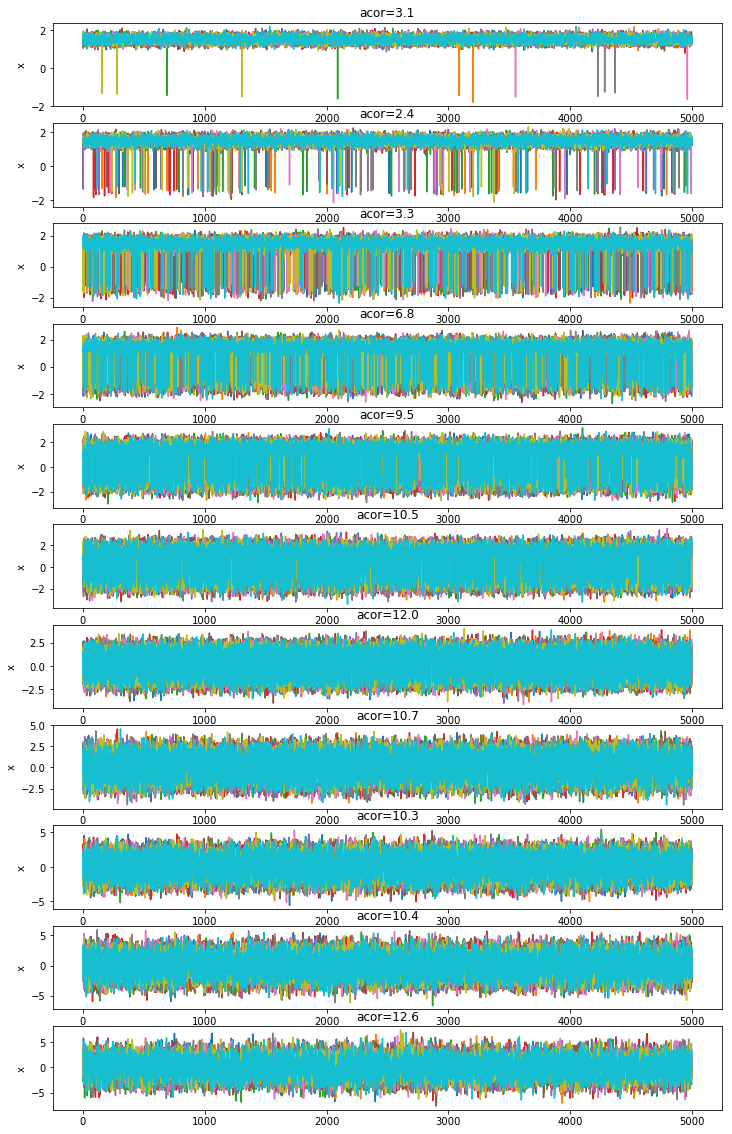

In [16]:
do_pt(11, 10, 5000, burnin=100)

Temps [  1.00000000e+00   7.00000000e+00   4.90000000e+01   3.43000000e+02
   2.40100000e+03   1.68070000e+04   1.17649000e+05   8.23543000e+05
   5.76480100e+06   4.03536070e+07   2.82475249e+08]
Got The chain is too short to reliably estimate the autocorrelation time while getting acor


(0.47825090909090912,
 [0.30331999999999998,
  0.47489999999999999,
  0.49564000000000002,
  0.50172000000000005,
  0.50471999999999995,
  0.50270000000000004,
  0.50116000000000005,
  0.49959999999999999,
  0.48964000000000002,
  0.49256,
  0.49480000000000002])

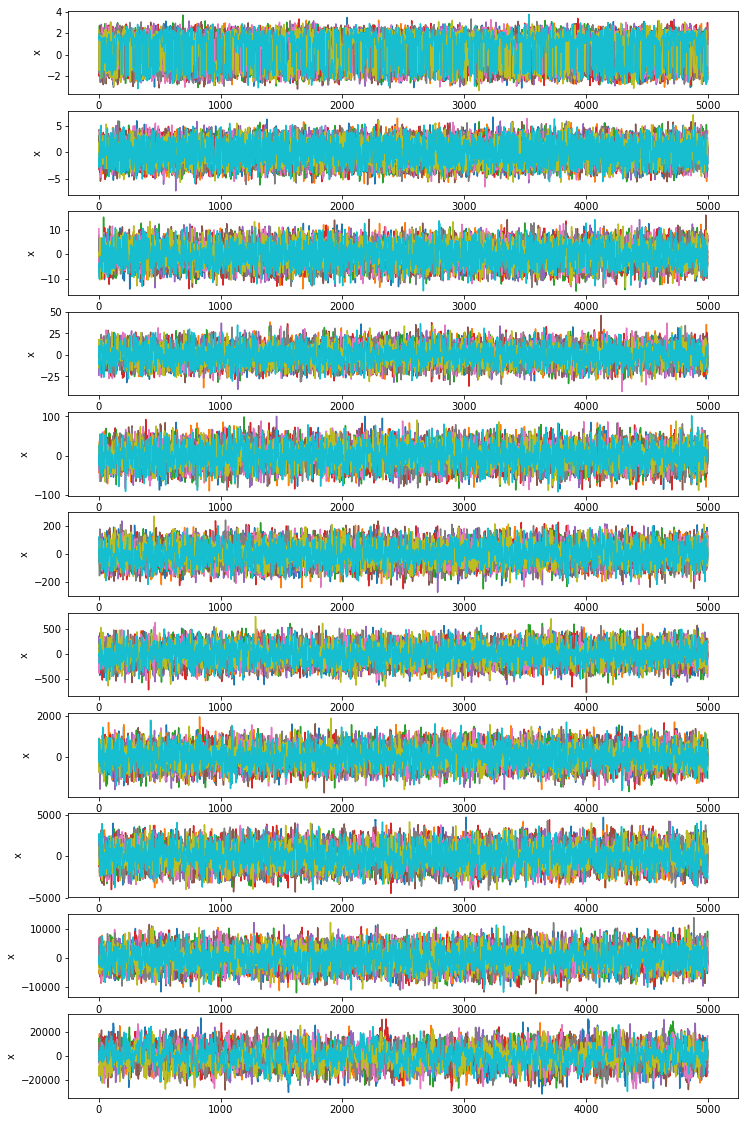

In [17]:
do_pt(11, 10, 5000, burnin=100, symtemps=False)

*only* the T=1 version gets the inter-mode fraction right